<a href="https://colab.research.google.com/github/avinashkpai12/Pytorch_Projects/blob/master/Callbacks_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Kaggle Cats vs Dogs Dataset

In [ ]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:15<00:00, 53.6MB/s]


In [ ]:
# Setting train and test directories
train_dir = './train'
test_dir = './test1'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [ ]:
print(f'Number of Images in {train_dir} is {len(train_files)}')
print(f'Number of Images in {test_dir} is {len(test_files)}')

Number of Images in ./train is 25000
Number of Images in ./test1 is 12500


In [ ]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/cat.6680.jpg


In [ ]:
# Creating transforms
transform = transforms.Compose([transforms.Resize((60,60)), transforms.ToTensor()])

In [ ]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0 

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [ ]:
# Creating train and test dataset objects
train = Dataset(train_files, train_dir, transform)
val = Dataset(test_files, test_dir, transform)

In [ ]:
# checking one data point
train.__getitem__(0)

(tensor([[[0.6000, 0.6118, 0.6314,  ..., 0.6235, 0.6706, 0.6824],
          [0.6000, 0.6118, 0.6235,  ..., 0.6392, 0.6706, 0.6824],
          [0.6000, 0.6078, 0.6157,  ..., 0.6471, 0.6706, 0.6824],
          ...,
          [0.5255, 0.4196, 0.3333,  ..., 0.2235, 0.4549, 0.4078],
          [0.5216, 0.5059, 0.4157,  ..., 0.1569, 0.4706, 0.4471],
          [0.4980, 0.3804, 0.3922,  ..., 0.1294, 0.4000, 0.5451]],
 
         [[0.5294, 0.5333, 0.5373,  ..., 0.6078, 0.6510, 0.6549],
          [0.5294, 0.5333, 0.5412,  ..., 0.6275, 0.6510, 0.6549],
          [0.5216, 0.5294, 0.5412,  ..., 0.6353, 0.6510, 0.6549],
          ...,
          [0.4824, 0.3647, 0.2902,  ..., 0.2588, 0.4745, 0.4157],
          [0.4745, 0.4471, 0.3647,  ..., 0.1843, 0.4863, 0.4510],
          [0.4471, 0.3176, 0.3373,  ..., 0.1294, 0.3922, 0.5294]],
 
         [[0.3451, 0.3373, 0.3176,  ..., 0.4392, 0.4902, 0.4941],
          [0.3451, 0.3373, 0.3255,  ..., 0.4549, 0.4902, 0.4941],
          [0.3373, 0.3373, 0.3333,  ...,

In [ ]:
print(train.__getitem__(0)[0].shape)
print(val.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


In [ ]:
# Creating train and validation split
train, val = torch.utils.data.random_split(train, [20000, 5000])

In [ ]:
# check after splitting data
print(len(train))
print(len(val))

20000
5000


In [ ]:
# Creating an array of labels
val_class_count = [val.__getitem__(x)[1] for x in range(len(val))]
print(len(val_class_count))

5000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


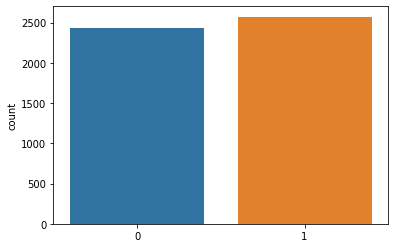

In [ ]:
import seaborn as sns

sns.countplot(val_class_count)

In [ ]:
# Creating dataloaders
train_dataset = torch.utils.data.DataLoader(
                                    dataset= train,
                                    batch_size=32,
                                    shuffle= True)
val_dataset = torch.utils.data.DataLoader(
                                    dataset= val, 
                                    batch_size=32,
                                     shuffle= False
                                     )

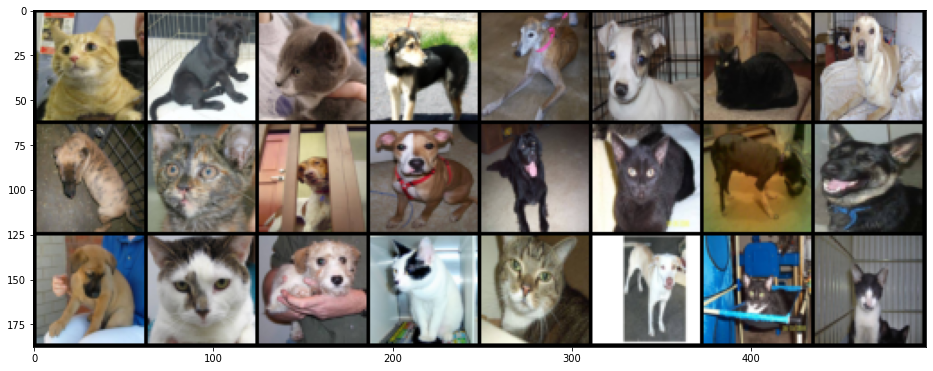

In [ ]:
# plotting some images from train dataset
samples, labels = iter(train_dataset).next()

plt.figure(figsize = (16, 24))
grid_images = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_images.numpy()

# Since we are loading a tensor image has (batch, width, height). we have to transpose it to (width, height, batch) in numpy
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))


In [ ]:
# Building the model
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU()
    )

    # Final FC layer to output two classes i.e., Cats/Dogs
    self.fc2 = nn.Sequential(
        nn.Linear(128,2)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.softmax(x, dim=1) 
    



In [ ]:
# Using torch summary to display model summary
model = CNN()
model.cuda()
summary(model, (3, 60, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [ ]:
# Defining Loss function and optimizer
# 1. Cross Entropy loss is used
# 2. Adam optimizer is used
# 3. epoch =10
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs=10

In [ ]:
# Using tqdm to perform Keras style training
# TQDM used to output progress bar
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
  model.train()
  total = 0
  correct = 0
  counter = 0
  train_running_loss = 0

  with tqdm(train_dataset, unit="batch") as tepoch:
    # Progress bar labels
    tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

    for data, label in tepoch:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data) # run one batch through model
      loss = criterion(output, label)
      loss.backward() # update the gradient
      optimizer.step()

      train_running_loss += loss.item() * data.size(0)

      _, pred = torch.max(output.data, 1)

      # Keeping trak of how many images have been fwd propagated
      total += label.size(0)
      # Keeping track of how many were predicted to be correct
      correct += (pred == label).sum().item()

    train_accuracy.append(correct/total)
    train_loss.append(train_running_loss/len(train_dataset))
    print(f'Epoch {epoch + 1} Training Accuracy = {correct/total}')
    print(f'Epoch {epoch + 1} Training Loss = {train_running_loss/len(train_dataset)}')

  # Calculating validation accuracy and loss
  if(epoch%1 == 0):
    model.eval()
    total =0
    correct = 0
    val_running_loss = 0

    # Gradients are not required for validation
    with torch.no_grad():
      for val_data, val_label in val_dataset:
        val_data, val_label =val_data.to(device), val_label.to(device)
        val_output = model(val_data)
        loss_val = criterion(val_output, val_label)

        # Calculating running loss
        val_running_loss += loss_val.item() * val_data.size(0)
        _, pred = torch.max(val_output.data, 1)
        total += val_label.size(0)
        correct += (pred == val_label).sum().item()

      val_accuracy.append(correct/total)
      val_loss.append(val_running_loss/len(val_dataset))

      print(f'Epoch {epoch + 1} Validation Accuracy = {correct/total}')
      print(f'Epoch {epoch + 1} Validation Loss = {val_running_loss/len(val_dataset)}')
      


In [ ]:
# Using Callbacks on existing model
# Defining Loss function and optimizer
# 1. Cross Entropy loss is used
# 2. Adam optimizer is used
# 3. epoch =10
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# learning rate scheduler. The below scheduler checks if the loss has not decreased for a specific number of epochs, we reduce the learning rate by a factor
# Patience = n : checks if the loss has not reduced for 'n' epochs
# factor = f : if the loss hasn't decreased, we decrease the LR by the factor f.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5, verbose= True)
epochs=20

In [ ]:
# Introducing leaning rate scheduler call back into the training process
# Using tqdm to perform Keras style training
# TQDM used to output progress bar
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
  model.train()
  total = 0
  correct = 0
  counter = 0
  train_running_loss = 0
  losses = []

  with tqdm(train_dataset, unit="batch") as tepoch:
    # Progress bar labels
    tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

    for data, label in tepoch:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data) # run one batch through model
      loss = criterion(output, label)

      losses.append(loss.item() * data.size(0))
      loss.backward() # update the gradient
      optimizer.step()

      train_running_loss += loss.item() * data.size(0)

      _, pred = torch.max(output.data, 1)

      # Keeping trak of how many images have been fwd propagated
      total += label.size(0)
      # Keeping track of how many were predicted to be correct
      correct += (pred == label).sum().item()

    train_accuracy.append(correct/total)
    train_loss.append(train_running_loss/len(train_dataset))
    mean_loss = sum(losses)/len(losses)
    # Using the schedulaer call back
    scheduler.step(mean_loss)
    print(f'Epoch {epoch + 1} Training Accuracy = {correct/total}')
    print(f'Epoch {epoch + 1} Training Loss = {train_running_loss/len(train_dataset)}')
    print(f'Cost at epoch {epoch + 1} is {mean_loss}')

  # Calculating validation accuracy and loss
  if(epoch%1 == 0):
    model.eval()
    total =0
    correct = 0
    val_running_loss = 0

    # Gradients are not required for validation
    with torch.no_grad():
      for val_data, val_label in val_dataset:
        val_data, val_label =val_data.to(device), val_label.to(device)
        val_output = model(val_data)
        loss_val = criterion(val_output, val_label)

        # Calculating running loss
        val_running_loss += loss_val.item() * val_data.size(0)
        _, pred = torch.max(val_output.data, 1)
        total += val_label.size(0)
        correct += (pred == val_label).sum().item()

      val_accuracy.append(correct/total)
      val_loss.append(val_running_loss/len(val_dataset))

      print(f'Epoch {epoch + 1} Validation Accuracy = {correct/total}')
      print(f'Epoch {epoch + 1} Validation Loss = {val_running_loss/len(val_dataset)}')